In [9]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt

In [10]:
#load the sample audio file as a floating point time series
filename = 'Small_audio_sample/131535.wav'
chirp_song, sr = librosa.load(filename)

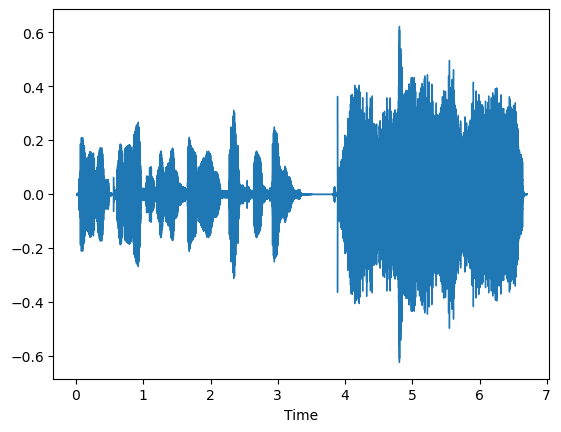

In [3]:
#visualize the waveform as a function of time
librosa.display.waveshow(chirp_song, sr=sr);

In [4]:
#Compute a short-time Fourier transform (stft) column matrix M with complex entries, starting three-fourths of the way into the file
n_fft = 2048
sample_start = int(chirp_song.shape[0]*.75)
M = librosa.stft(chirp_song[sample_start:sample_start+n_fft], n_fft=n_fft, hop_length=n_fft+1)

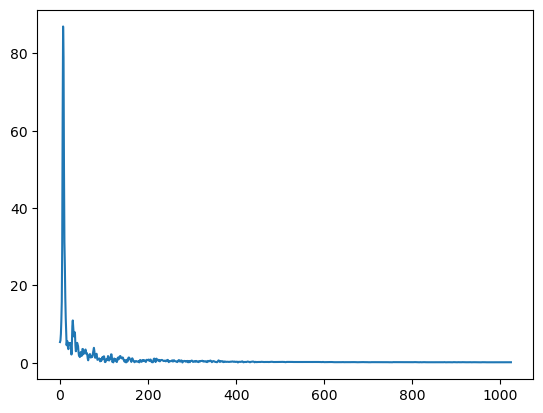

In [5]:
#Plot the absolute value of the entries (the spectromgram)
plt.plot(abs(M))

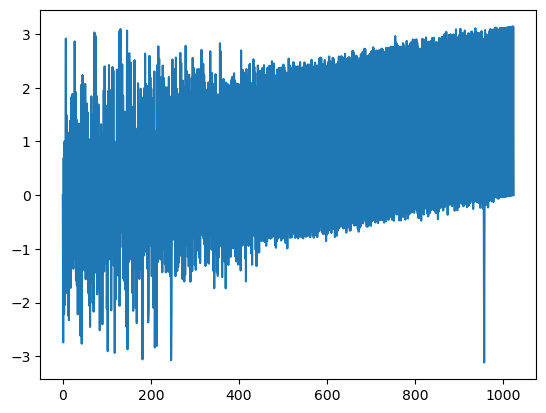

In [6]:
#Plot the phase (=angle) of entries
plt.plot(np.angle(M))

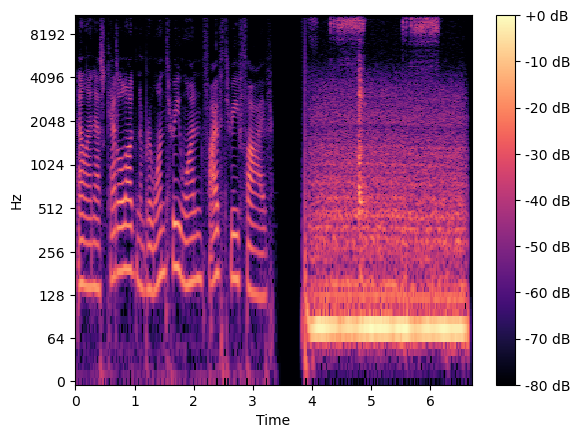

In [7]:
#The Mel spectrogram
#Divide the file into small segments and apply the stft to each. Then along each vertical segment, plot the volume (dB) at each corresponding pitch (Hz) 
hop_length = 512
n_fft = 2048
D = np.abs(librosa.stft(chirp_song, n_fft=n_fft,  hop_length=hop_length))
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

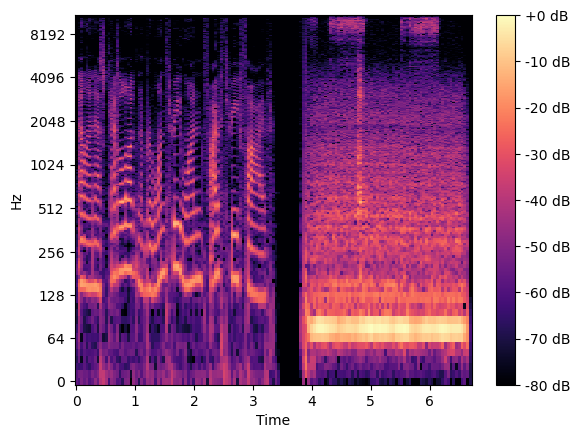

In [8]:
#same but more samples(=hop_length) between each column (so less computation)
hop_length = 1024
n_fft = 2048
D = np.abs(librosa.stft(chirp_song, n_fft=n_fft,  hop_length=hop_length))
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');